In [1]:
# All imports needed for the notebook
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor   
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedKFold, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
from tqdm import trange
import skgstat as skg

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Load data
Load the Airbnb dataset from `airbnb_clean.csv` for analysis.


In [2]:
import pandas as pd
import numpy as np

# Load the cleaned Airbnb dataset
df = pd.read_csv('../data/airbnb/airbnb_clean.csv')

# Features: all columns except 'price'
X = df.drop(['price'], axis=1)

# Target: price
y = df['price'].values

# Coordinates for spatial CV (assumes columns are named 'longitude' and 'latitude')
coords = df[['longitude', 'latitude']].values


## Pipeline & models
- **Preprocessing:** median-impute + scale numeric; most-frequent-impute + one-hot categorical.  
- **Model:** **Ridge** regression (fast). You can switch to **RandomForestRegressor** below.


In [3]:
# Preprocessing
num_tf = Pipeline([("scaler", StandardScaler())])

# All features are numeric, so use all columns
preprocess = ColumnTransformer([("num", num_tf, X.columns.tolist())], remainder="drop")

# Choose model here
rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=2, n_jobs=-1, random_state=42)
rf = SGDRegressor(random_state=42)

# Active pipeline (Random Forest)
pipe = Pipeline([("prep", preprocess), ("model", rf)])

print(pipe)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['accommodates', 'bedrooms',
                                                   'beds', 'bathrooms',
                                                   'guests_included',
                                                   'reviews_per_month',
                                                   'number_of_reviews',
                                                   'host_listings_count',
                                                   'longitude',
                                                   'latitude'])])),
                ('model', SGDRegressor(random_state=42))])


In [4]:
# After loading, update numeric_cols and rebuild pipeline

numeric_cols = X.columns.tolist()

preprocess = ColumnTransformer([("num", num_tf, numeric_cols)], remainder="drop")

pipe = Pipeline([("prep", preprocess), ("model", rf)])

print("Pipeline rebuilt with columns:", numeric_cols)

Pipeline rebuilt with columns: ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'guests_included', 'reviews_per_month', 'number_of_reviews', 'host_listings_count', 'longitude', 'latitude']


In [5]:
def assign_blocks(
    coords: np.ndarray,
    method: str = 'grid',
    n_blocks: int = 5,
    grid_aspect: str = 'auto',
    random_state: int = 42,
    **kwargs
) -> tuple:
    """
    Assign spatial blocks to coordinates using either a grid or k-means clustering.

    Parameters
    ----------
    coords : np.ndarray
        Array of shape (n_samples, 2) with spatial coordinates.
    method : str, optional
        Block assignment method: 'grid' or 'kmeans'. Default is 'grid'.
    n_blocks : int, optional
        Number of blocks to assign. For 'grid', will use closest square grid.
    grid_aspect : str, optional
        'auto' for square grid, or 'rect' for rectangular grid (future extension).
    random_state : int, optional
        Random seed for k-means. Default is 42.
    **kwargs
        Additional arguments passed to KMeans or future grid options.

    Returns
    -------
    groups : np.ndarray
        Array of group/block assignments for each coordinate.
    block_info : dict
        Dictionary with grid metadata if method='grid', clustering metadata if method='kmeans'.

    Raises
    ------
    ValueError
        If method is not recognized or input is invalid.
    """
    # Input validation
    if not isinstance(coords, np.ndarray):
        raise TypeError("coords must be a numpy array")
    if coords.ndim != 2 or coords.shape[1] != 2:
        raise ValueError("coords must be of shape (n_samples, 2)")
    if n_blocks < 1:
        raise ValueError("n_blocks must be >= 1")

    if method == 'grid':
        # Square grid: find closest integer for cells per side
        cells_per_side = int(np.ceil(np.sqrt(n_blocks)))
        mins = coords.min(axis=0)
        maxs = coords.max(axis=0)
        span = np.maximum(maxs - mins, 1e-9)
        cell = span / cells_per_side
        ij = np.floor((coords - mins) / cell).astype(int)
        # Clip indices to grid bounds
        ij = np.clip(ij, 0, cells_per_side - 1)
        # Encode group as integer
        groups = ij[:, 0] * cells_per_side + ij[:, 1]
        block_info = {
            'mins': mins,
            'maxs': maxs,
            'cell': cell,
            'cells_per_side': cells_per_side,
            'n_blocks': cells_per_side ** 2,
            'method': 'grid'
        }
        return groups, block_info

    elif method == 'kmeans':
        if n_blocks > coords.shape[0]:
            raise ValueError("n_blocks cannot exceed number of samples for kmeans")
        kmeans = KMeans(n_init='auto', n_clusters=n_blocks, random_state=random_state, **kwargs)
        groups = kmeans.fit_predict(coords)
        block_info = {
            'n_blocks': n_blocks,
            'method': 'kmeans',
            'inertia': kmeans.inertia_
        }
        return groups, block_info

    else:
        raise ValueError(f"Unknown method: {method}. Use 'grid' or 'kmeans'.")

In [6]:
def plot_partition(coords: np.ndarray, groups: np.ndarray, block_info: dict = None,
                  figsize: tuple = (8, 6), point_size: int = 10, cmap: str = 'tab20',
                  show_legend: bool = True, ax=None, title: str = None, max_groups: int = 20) -> None:
    """
    Visualize any spatial block/group partition (grid, k-means, etc), limiting the number of groups plotted.

    Parameters
    ----------
    coords : np.ndarray
        Array of shape (n_samples, 2) with spatial coordinates.
    groups : np.ndarray
        Array of group/block assignments for each coordinate.
    block_info : dict, optional
        Dictionary with grid or clustering metadata. If grid, draws grid lines.
    figsize : tuple, optional
        Figure size for the plot. Default is (8, 6).
    point_size : int, optional
        Size of scatter plot points. Default is 10.
    cmap : str, optional
        Colormap for group coloring. Default is 'tab20'.
    show_legend : bool, optional
        Whether to show legend for groups. Default is True.
    ax : matplotlib.axes.Axes, optional
        Existing matplotlib axis to plot on. If None, creates new figure.
    title : str, optional
        Title for the plot. If None, uses block_info['method'] if available.
    max_groups : int, optional
        Maximum number of unique groups to plot. Others are ignored. Default is 20.

    Returns
    -------
    None
    """
    import matplotlib.pyplot as plt
    import numpy as np

    unique_groups = np.unique(groups)
    if len(unique_groups) > max_groups:
        # Only plot the first max_groups groups
        selected_groups = unique_groups[:max_groups]
        mask = np.isin(groups, selected_groups)
        coords = coords[mask]
        groups = groups[mask]
        legend_note = f"(showing first {max_groups} groups)"
    else:
        legend_note = None

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    scatter = ax.scatter(coords[:, 0], coords[:, 1], c=groups, cmap=cmap, s=point_size, alpha=0.8, edgecolor='none')

    # Draw grid lines if grid partition
    if block_info is not None and block_info.get('method') == 'grid':
        mins = block_info['mins']
        cell = block_info['cell']
        cells_per_side = block_info['cells_per_side']
        for i in trange(1, cells_per_side):
            x = mins[0] + i * cell[0]
            ax.axvline(x, color='gray', linestyle='--', linewidth=0.7, alpha=0.7)
            y = mins[1] + i * cell[1]
            ax.axhline(y, color='gray', linestyle='--', linewidth=0.7, alpha=0.7)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    if title is not None:
        ax.set_title(title)
    elif block_info is not None and 'method' in block_info:
        ax.set_title(f"Partition ({block_info['method'].capitalize()} Blocks)")
    else:
        ax.set_title('Spatial Partition (Blocks)')

    if show_legend:
        import matplotlib.patches as mpatches
        unique_groups = np.unique(groups)
        colors = [scatter.cmap(scatter.norm(g)) for g in unique_groups]
        handles = [mpatches.Patch(color=col, label=f'Block {g}') for g, col in zip(unique_groups, colors)]
        ax.legend(handles=handles, title='Block Group', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')


def plot_buffered_cv_partitions(coords, X, y, groups, buffer_m, max_blocks=20, ncols=4, point_size=5, figsize_scale=5):
    """
    Modular visualization of buffered spatial CV partitions for any block assignment.
    Shows train (buffered), excluded by buffer, and test fold for each block.
    Parameters:
        coords: np.ndarray, shape (n_samples, 2)
        X: pd.DataFrame or np.ndarray
        y: np.ndarray
        groups: np.ndarray, block assignments
        buffer_m: float, buffer radius in same units as coords
        max_blocks: int, max number of blocks to plot
        ncols: int, number of columns in subplot grid
        point_size: int, size for all points
        figsize_scale: int, scale for figure size
    """
    from sklearn.model_selection import GroupKFold
    from scipy.spatial import cKDTree
    import numpy as np
    import matplotlib.pyplot as plt
    
    unique_blocks = np.unique(groups)
    n_blocks = min(len(unique_blocks), max_blocks)
    nrows = int(np.ceil(n_blocks / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize_scale*ncols, figsize_scale*nrows), squeeze=False)
    
    gkf = GroupKFold(n_splits=n_blocks)
    tree = cKDTree(coords)
    
    for i, (tr_all, te) in enumerate(gkf.split(X, y, groups=groups)):
        if i >= n_blocks:
            break
        neigh_lists = tree.query_ball_point(coords[te], r=buffer_m)
        banned = np.unique(np.concatenate(neigh_lists)) if len(neigh_lists) else np.array([], dtype=int)
        tr_buffered = np.setdiff1d(tr_all, banned, assume_unique=False)
        ax = axes[i // ncols][i % ncols]
        ax.scatter(coords[tr_buffered,0], coords[tr_buffered,1], c='blue', s=point_size, label='Train (buffered)')
        ax.scatter(coords[banned,0], coords[banned,1], c='orange', s=point_size, label='Excluded by buffer')
        ax.scatter(coords[te,0], coords[te,1], c='red', s=point_size, label='Test fold')
        ax.set_title(f'Block {i+1} (Buffer={buffer_m:.0f} m)')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend(loc='best', fontsize='small')
    
    # Hide unused subplots
    for j in range(i+1, nrows*ncols):
        axes[j // ncols][j % ncols].axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_buffered_loo_iteration(coords, buffer_m, test_idx=None, ax=None, point_size=10):
    """
    Plot a single iteration of buffered leave-one-out CV.
    Shows: test point, training points (outside buffer), excluded points (inside buffer).
    """
    n = coords.shape[0]
    if test_idx is None:
        test_idx = random.randint(0, n-1)
    tree = cKDTree(coords)
    banned = tree.query_ball_point(coords[test_idx], r=buffer_m)
    banned = np.array(banned)
    tr = np.setdiff1d(np.arange(n), banned, assume_unique=True)
    
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 6))
    
    # Plot training points (outside buffer)
    ax.scatter(coords[tr,0], coords[tr,1], c='blue', s=point_size, label='Train (outside buffer)', alpha=0.7)
    # Plot excluded points (inside buffer, not test)
    excluded = np.setdiff1d(banned, [test_idx], assume_unique=True)
    ax.scatter(coords[excluded,0], coords[excluded,1], c='orange', s=point_size, label='Excluded by buffer', alpha=0.7)
    # Plot test point
    ax.scatter(coords[test_idx,0], coords[test_idx,1], c='red', s=point_size*2, label='Test point', edgecolor='black', linewidth=1.5, zorder=10)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Buffered LOO CV (Buffer={buffer_m:.0f} m), Test idx={test_idx}')
    ax.legend(loc='best', fontsize='small')
    plt.show()    


## Cross-validation utilities
- **Random CV:** Repeated K-fold.  
- **Spatial blocks:** GroupKFold on grid cells.  
- **Buffered spatial CV:** additionally drop training points within *buffer* meters of test fold.


In [7]:
def rmse(a,b): 
    return float(np.sqrt(mean_squared_error(a,b)))


def random_cv_scores(pipe, X, y, n_splits=5, n_repeats=3, seed=123):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    scores = []
    for tr, te in rkf.split(X):
        pipe.fit(X.iloc[tr], y[tr])
        yp = pipe.predict(X.iloc[te])
        scores.append(rmse(y[te], yp))
    return np.array(scores)

def spatial_cv_scores(pipe, X, y, groups, n_splits=5):
    uniq = np.unique(groups)
    current_n_splits = min(n_splits, len(uniq)) if len(uniq) >= 2 else 2
    gkf = GroupKFold(n_splits=current_n_splits)
    scores = []
    for tr, te in gkf.split(X, y, groups=groups):
        pipe.fit(X.iloc[tr], y[tr])
        yp = pipe.predict(X.iloc[te])
        scores.append(rmse(y[te], yp))
    return np.array(scores)


def buffered_spatial_cv_scores(pipe, X, y, coords, groups, buffer_m, n_splits=5):
    tree = cKDTree(coords)
    uniq = np.unique(groups)
    current_n_splits = min(n_splits, len(uniq)) if len(uniq) >= 2 else 2
    gkf = GroupKFold(n_splits=current_n_splits)
    scores = []
    for tr_all, te in gkf.split(X, y, groups=groups):
        # drop training points within buffer of any test point
        neigh_lists = tree.query_ball_point(coords[te], r=buffer_m)
        banned = np.unique(np.concatenate(neigh_lists)) if len(neigh_lists) else np.array([], dtype=int)
        tr = np.setdiff1d(tr_all, banned, assume_unique=False)
        if tr.size < 20:  # fallback if too aggressive
            tr = tr_all
        pipe.fit(X.iloc[tr], y[tr])
        yp = pipe.predict(X.iloc[te])
        scores.append(rmse(y[te], yp))
    return np.array(scores)

In [8]:
def compute_buffer(coords, k=6):
    """Compute buffer distance as the median distance to the k-th nearest neighbor (default k=6)."""
    from scipy.spatial import cKDTree
    tree = cKDTree(coords)
    dists, _ = tree.query(coords, k=k)
    buffer_m = float(np.median(dists[:, k-1]))
    return buffer_m


## Run the evaluations
This will compute RMSE for:
- Random CV,
- Spatial block CV (5 folds),
- Buffered Spatial CV (buffer ≈ median 5th-NN distance in meters).


In [9]:
n_blocks = 10 # number of spatial blocks

100%|██████████| 3/3 [00:00<00:00, 1590.76it/s]



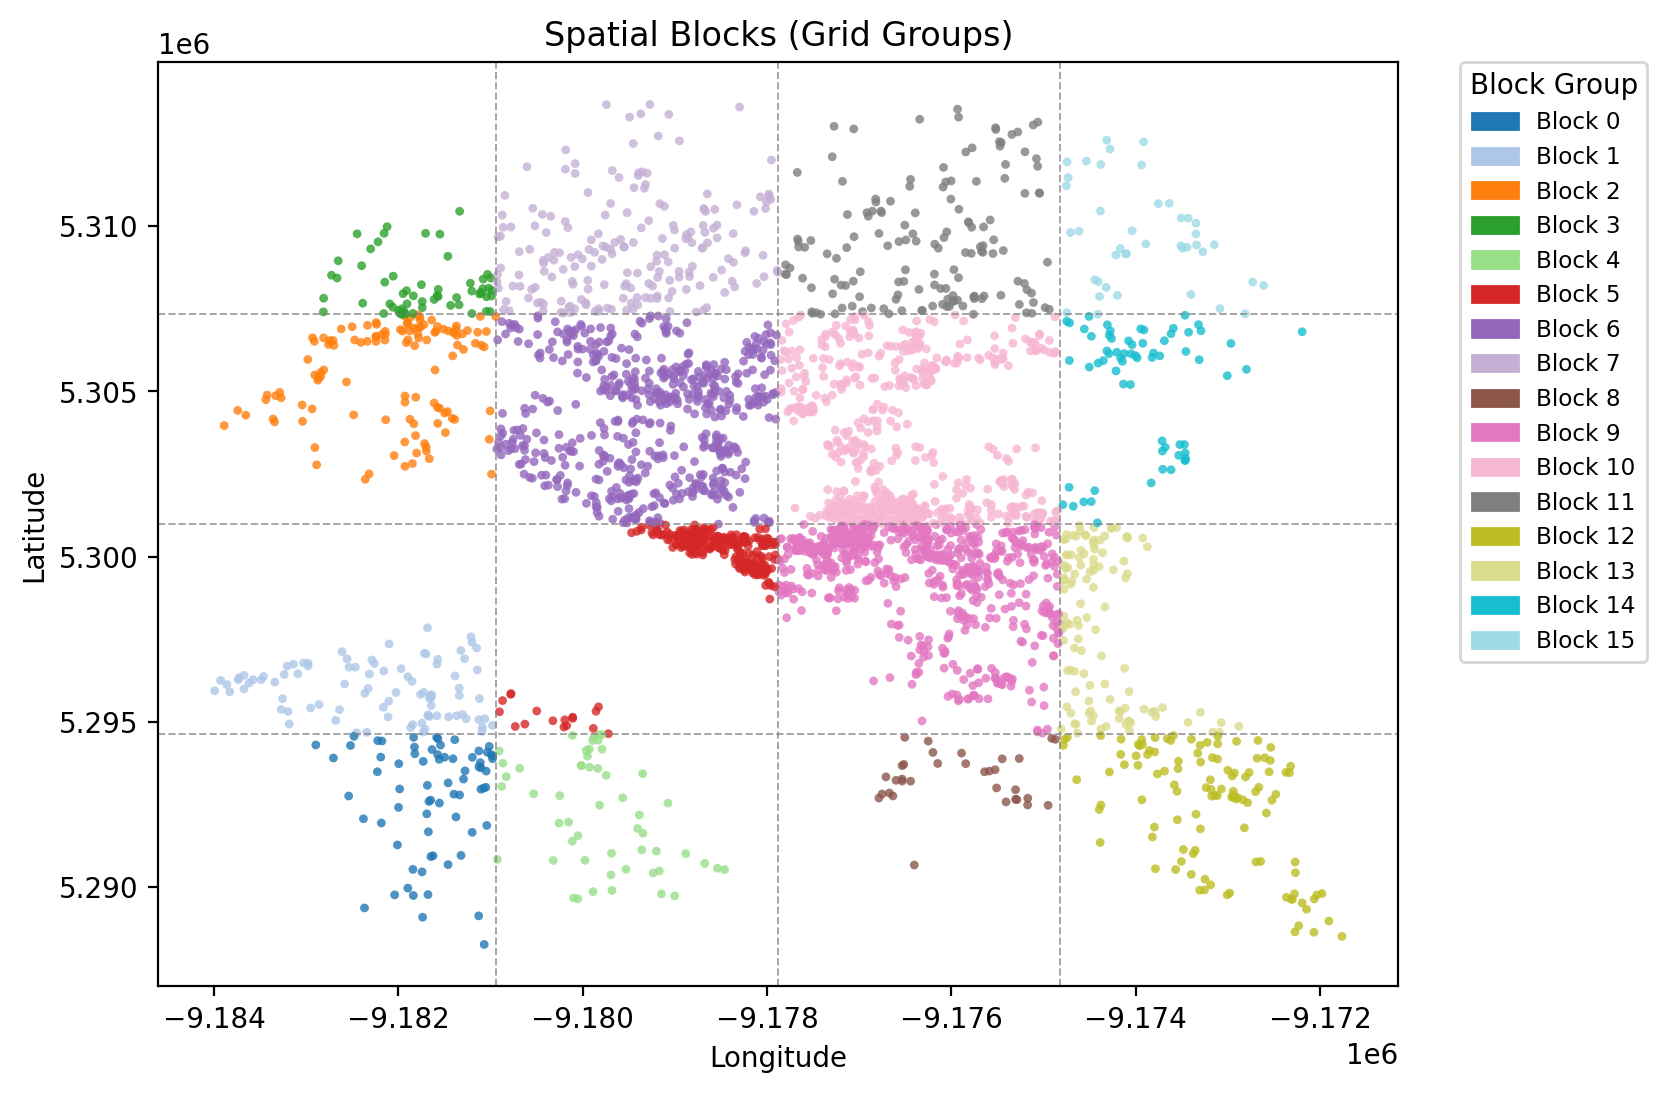

In [10]:
groups, grid_info = assign_blocks(coords, method="grid", n_blocks=n_blocks)

plot_partition(coords, groups, block_info=grid_info,
               figsize=(8, 6), point_size=10, cmap='tab20', show_legend=True,
               title='Spatial Blocks (Grid Groups)')

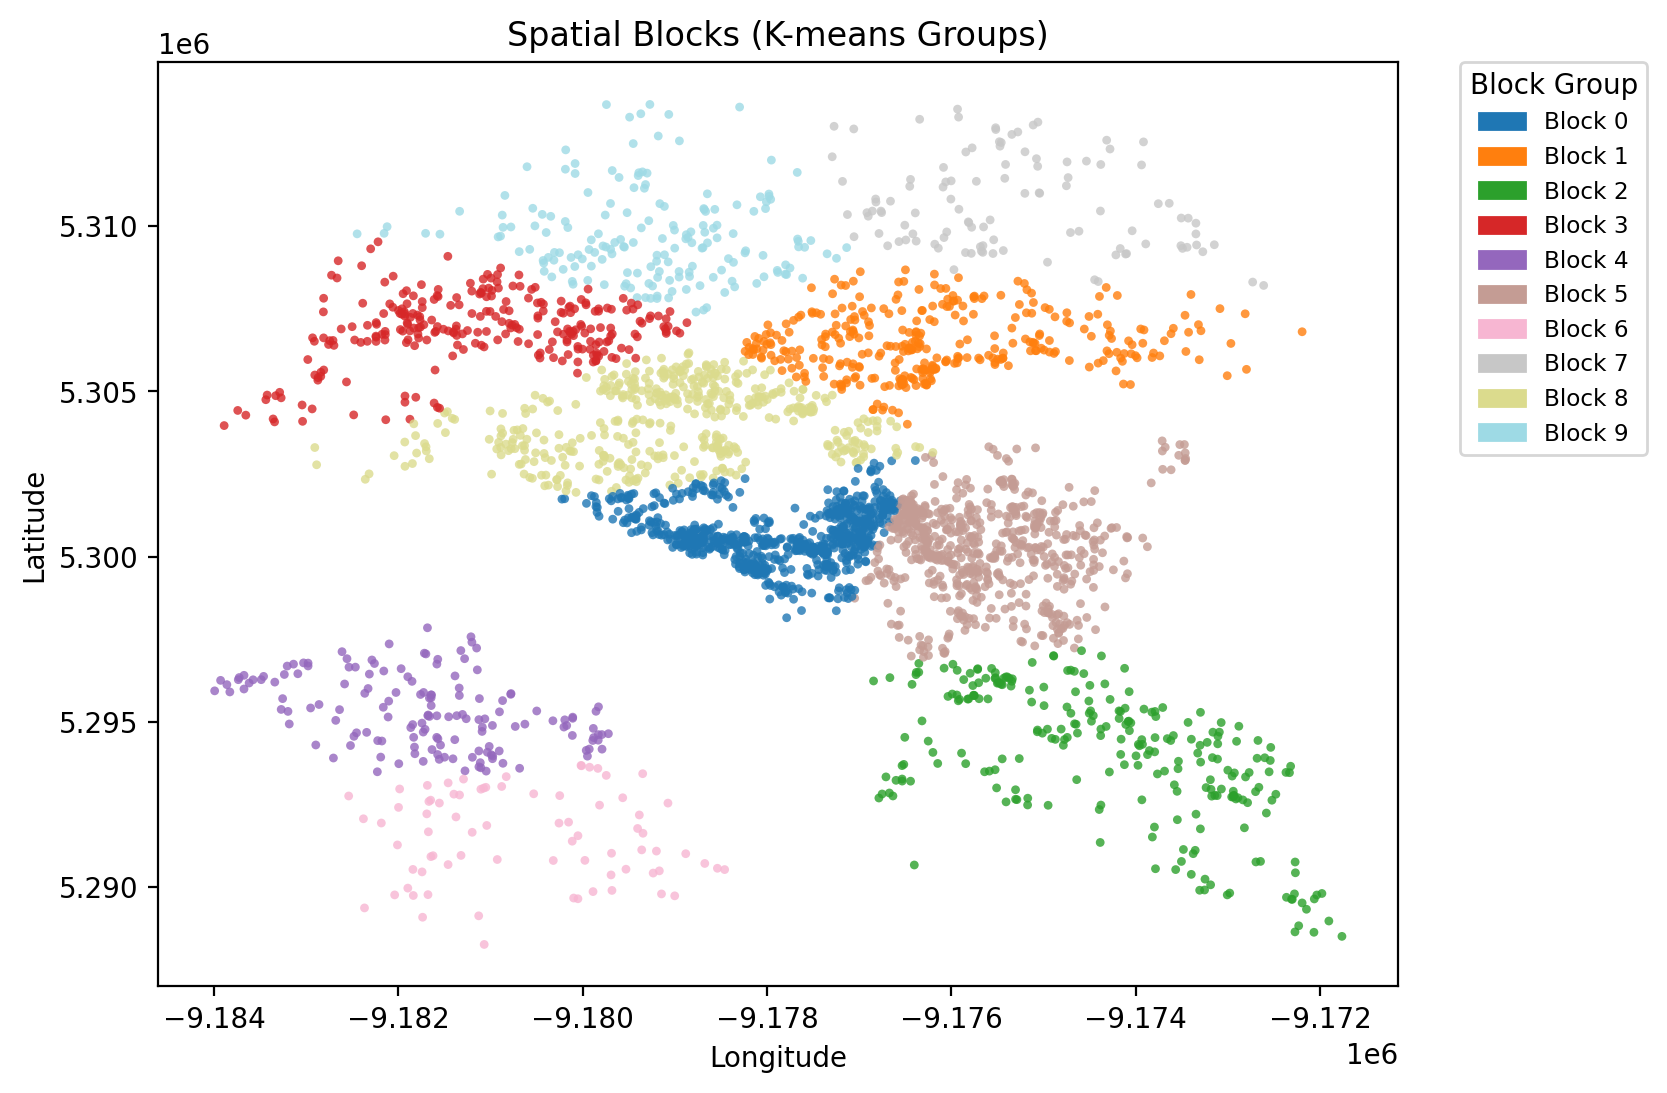

In [11]:
groups_kmeans, kmeans_info = assign_blocks(coords, method='kmeans', n_blocks=n_blocks)

plot_partition(coords, groups_kmeans, block_info=kmeans_info,
               figsize=(8, 6), point_size=10, cmap='tab20', show_legend=True,
               title='Spatial Blocks (K-means Groups)')

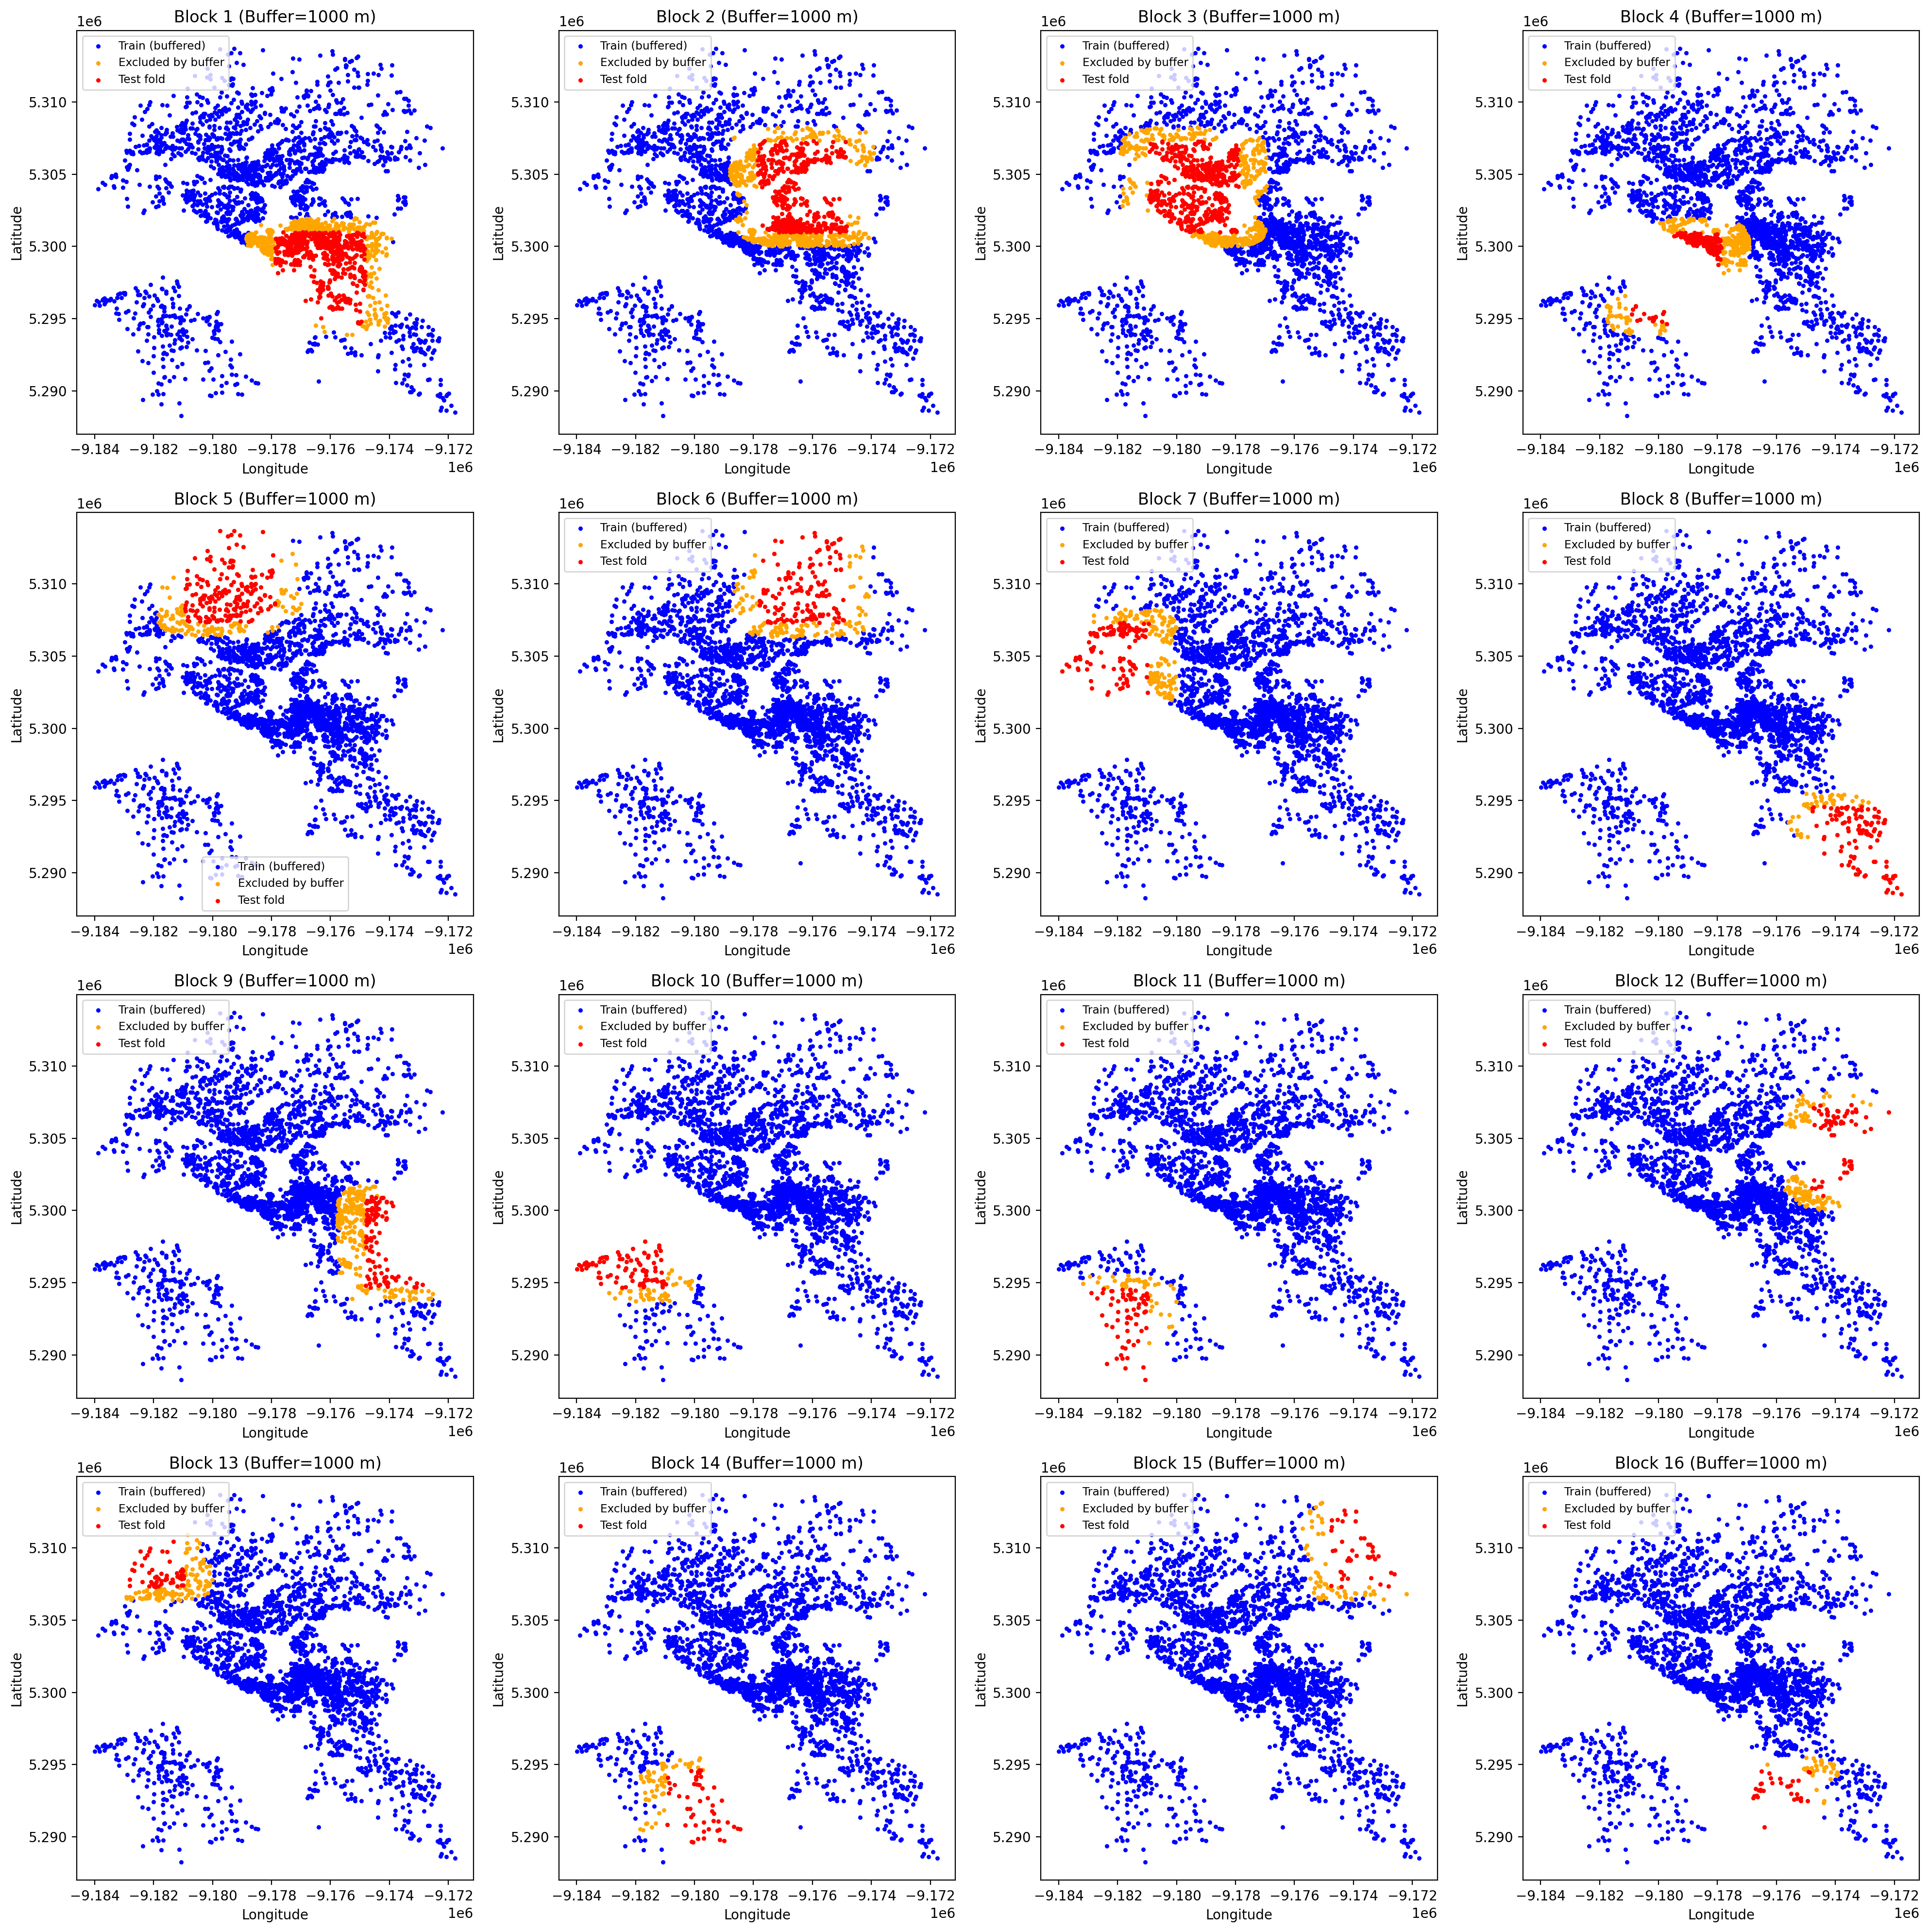

In [12]:
# Example usage:
plot_buffered_cv_partitions(coords, X, y, groups, 1000)

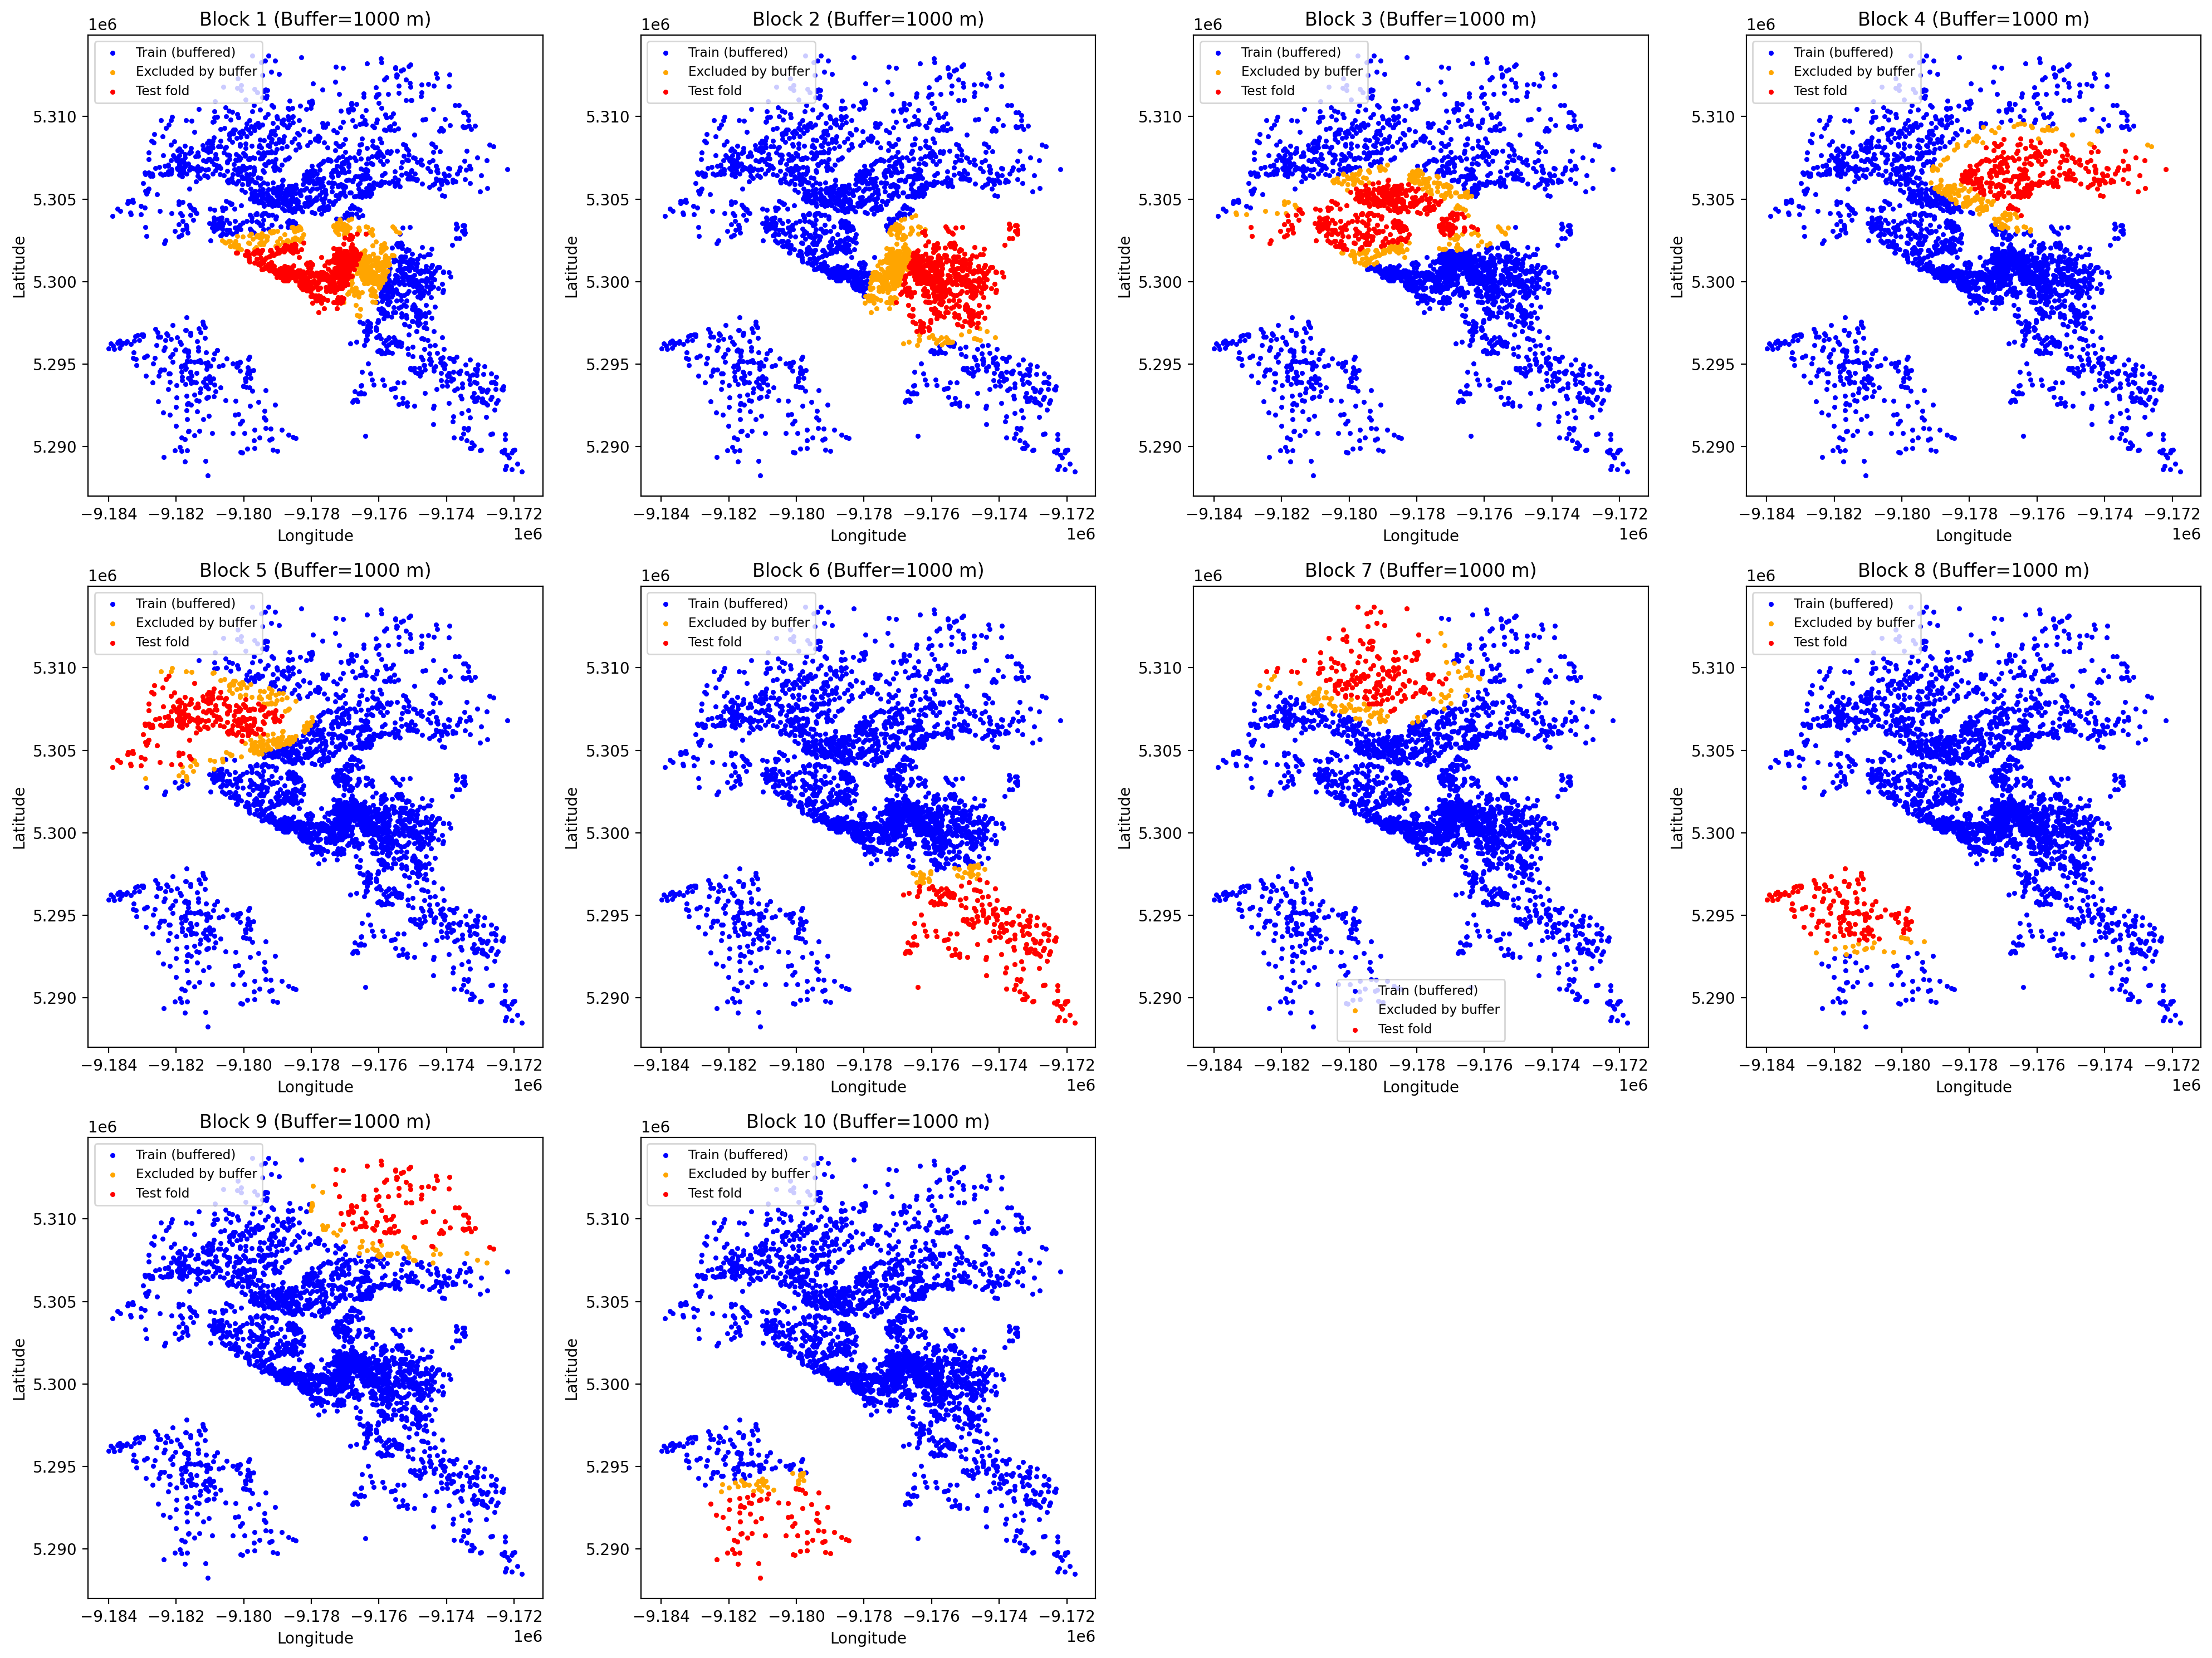

In [13]:
plot_buffered_cv_partitions(coords, X, y, groups_kmeans, 1000)

Buffer distance estimated from semivariogram range: 2705 meters


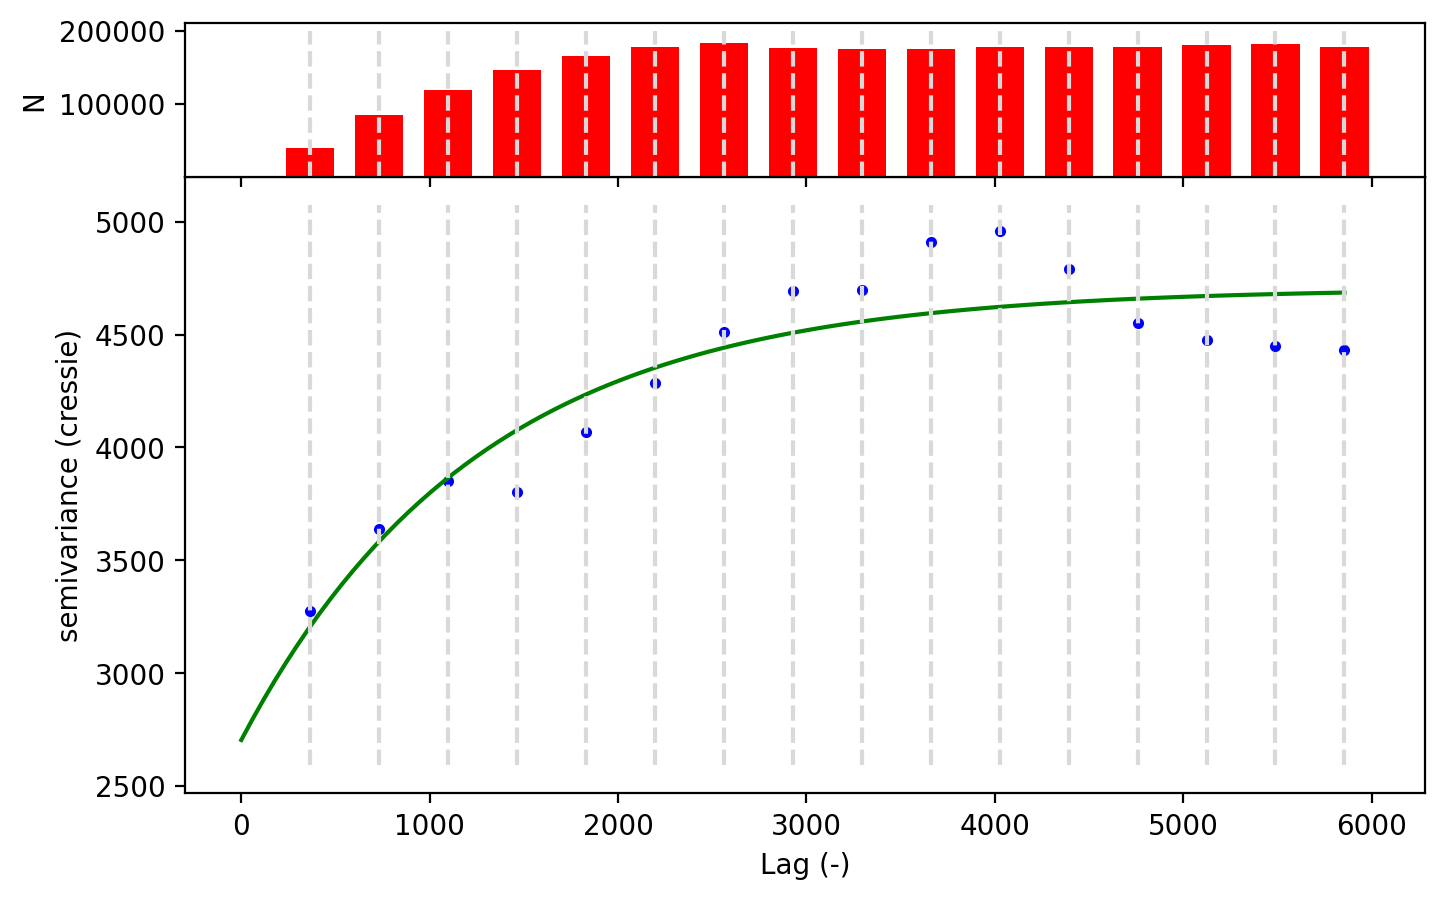

In [14]:
# Compute empirical semivariogram and extract spatial range as buffer distance
V = skg.Variogram(
    coordinates=coords,
    values=y,
    model='exponential',
    n_lags=16,
    maxlag='median',
    use_nugget=True,
    estimator='cressie')
 
V.plot()

print(f"Buffer distance estimated from semivariogram range: {V.parameters[2]:.0f} meters")

semivariogram_buffer_m = V.parameters[2]


In [15]:
n_splits = 5
buffer_m = semivariogram_buffer_m

rand_scores = random_cv_scores(pipe, X, y, n_splits=n_splits, seed=123)
spat_scores = spatial_cv_scores(pipe, X, y, groups, n_splits=n_splits)
buf_scores = buffered_spatial_cv_scores(pipe, X, y, coords, groups, buffer_m=buffer_m, n_splits=n_splits)

summary = pd.DataFrame({
    "CV": ["Random", "Spatial blocks", f"Buffered spatial (~{buffer_m:.0f} m)"],
    "RMSE_mean": [rand_scores.mean(), spat_scores.mean(), buf_scores.mean()],
    "n_folds":   [rand_scores.size,   spat_scores.size,   buf_scores.size],
})

summary

,CV,RMSE_mean,n_folds
0,Random,64.699005,15
1,Spatial blocks,66.103705,5
2,Buffered spatial (~2705 m),75.726112,5


## Buffered Leave-One-Out Spatial Cross-Validation
This method tests model generalization at individual locations, but with strict spatial independence: for each test point, all training points within a buffer distance are excluded. This is especially useful for dense spatial samples and helps avoid information leakage due to spatial autocorrelation.

Below is an implementation for the Airbnb dataset.

In [16]:
def buffered_loo_cv_scores(pipe, X, y, coords, buffer_m, max_iter=None):
    """
    Buffered Leave-One-Out Spatial Cross-Validation.
    For each observation, use it as the test set, and exclude all training points within buffer_m of the test point.
    Returns array of RMSEs (one per test point).
    """

    n = len(y) if max_iter is None else min(len(y), max_iter)
    tree = cKDTree(coords)
    scores = []

    for i in trange(n):
        banned = tree.query_ball_point(coords[i], r=buffer_m)
        tr = np.setdiff1d(np.arange(n), banned, assume_unique=False)
        
        pipe.fit(X.iloc[tr], y[tr])
        yp = pipe.predict(X.iloc[[i]])
        scores.append(rmse(y[[i]], yp))
    return np.array(scores)

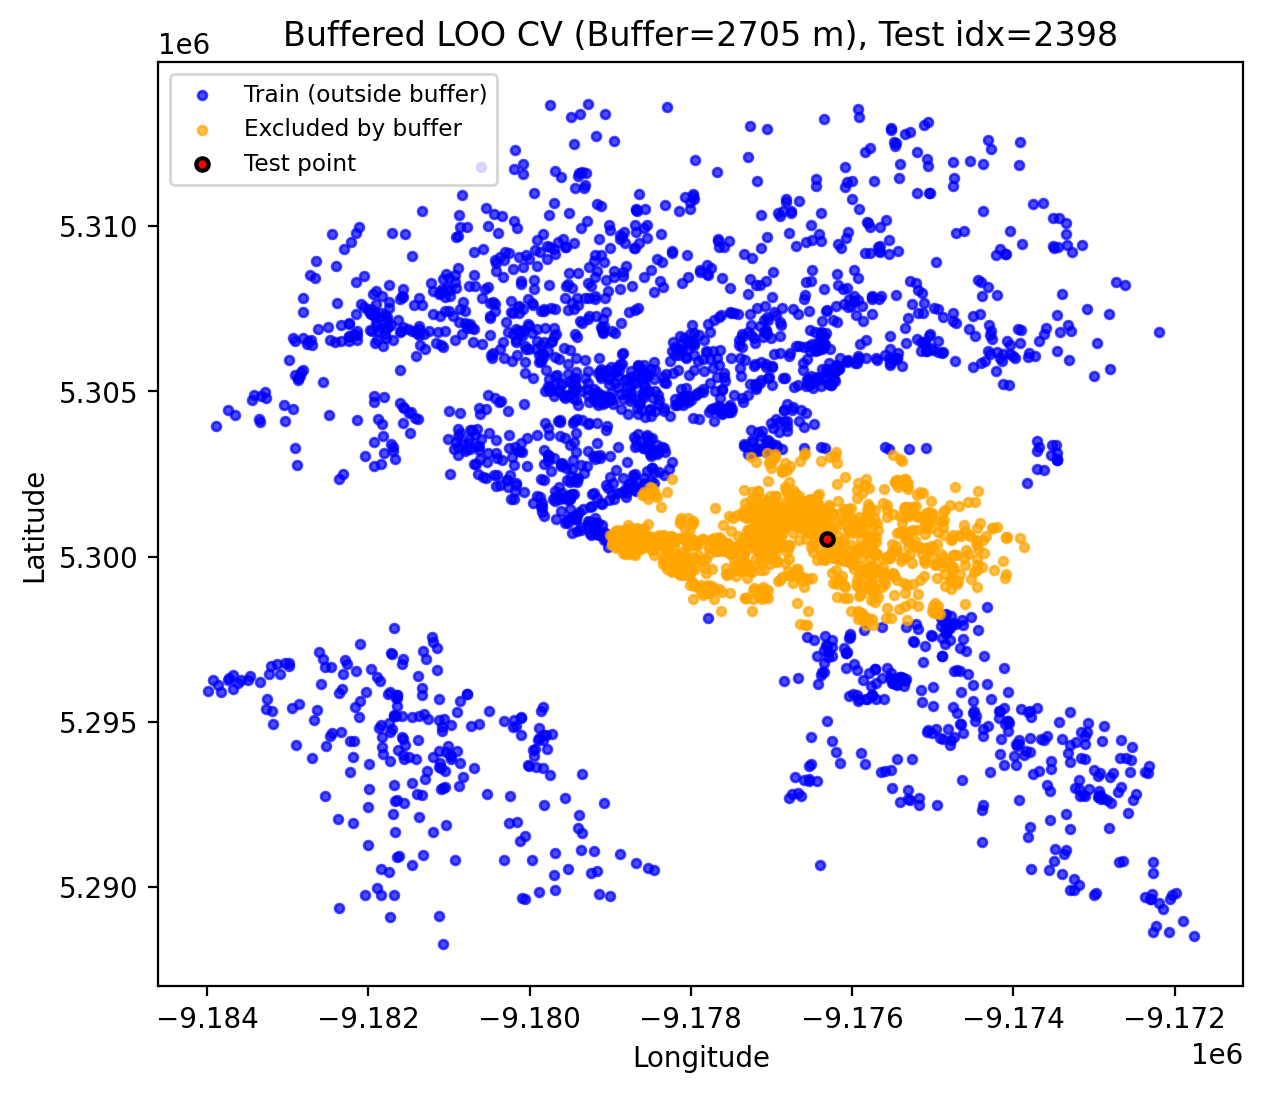

In [17]:
plot_buffered_loo_iteration(coords, buffer_m=semivariogram_buffer_m)

In [18]:
# Add to summary table
buffered_loo_scores = buffered_loo_cv_scores(pipe, X, y, coords, buffer_m=semivariogram_buffer_m)
loo_scores = buffered_loo_cv_scores(pipe, X, y, coords, buffer_m=0)

100%|██████████| 3173/3173 [00:10<00:00, 310.10it/s]


In [19]:
summary = pd.DataFrame({
    "CV": [
        "Random",
        "LOO (no buffer)",
        f"Buffered LOO (~{buffer_m:.0f} m)"
    ],
    "RMSE_mean": [
        rand_scores.mean(),
        loo_scores.mean(),
        buffered_loo_scores.mean()
    ],
    "RMSE_var": [
        rand_scores.var(),
        loo_scores.var(),
        buffered_loo_scores.var()
    ],
    "n_folds": [
        rand_scores.size,
        loo_scores.size,
        buffered_loo_scores.size
    ],
})
summary

,CV,RMSE_mean,RMSE_var,n_folds
0,Random,64.699005,20.542902,15
1,LOO (no buffer),40.742088,2527.344237,3173
2,Buffered LOO (~2705 m),45.222757,2712.007992,3173
